# Testing on inferencing UD

In [1]:
import pandas as pd
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModelForTokenClassification
from sklearn.metrics import classification_report
import evaluate
from seqeval.metrics import classification_report as seqeval_report
from seqeval.metrics import f1_score as seqeval_f1

# Define paths
# model_path = "BERT-Style-model/FacebookAI/roberta-large-10-epoch-32bs"
model_path = "BERT-Style-model/microsoft/deberta-v3-large-12-epoch-4bs-1028-mt"
test_data_path = "../corpus-raymond/usecase-test-hf.csv"
output_path = "inference-test"

# Create output directory if it doesn't exist
import os
os.makedirs(output_path, exist_ok=True)

In [2]:
# Define label mappings (same as in training)
iob_mapping = {
    "O": 0,
    "B-actor": 1,
    "I-actor": 2,
    "B-usecase": 3,
    "I-usecase": 4
}

label_names = ['O', 'B-actor', 'I-actor', 'B-usecase', 'I-usecase']

id2label = {i: label for i, label in enumerate(label_names)}
label2id = {v: k for k, v in id2label.items()}
id2label[5] = "[PAD]"
label2id["[PAD]"] = 5
print(id2label)
print(label2id)

{0: 'O', 1: 'B-actor', 2: 'I-actor', 3: 'B-usecase', 4: 'I-usecase', 5: '[PAD]'}
{'O': 0, 'B-actor': 1, 'I-actor': 2, 'B-usecase': 3, 'I-usecase': 4, '[PAD]': 5}


In [3]:
# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForTokenClassification.from_pretrained(model_path)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model.to(device)

Using device: cuda


DebertaV2ForTokenClassification(
  (deberta): DebertaV2Model(
    (embeddings): DebertaV2Embeddings(
      (word_embeddings): Embedding(128100, 1024, padding_idx=0)
      (LayerNorm): LayerNorm((1024,), eps=1e-07, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): DebertaV2Encoder(
      (layer): ModuleList(
        (0-23): 24 x DebertaV2Layer(
          (attention): DebertaV2Attention(
            (self): DisentangledSelfAttention(
              (query_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (key_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (value_proj): Linear(in_features=1024, out_features=1024, bias=True)
              (pos_dropout): Dropout(p=0.1, inplace=False)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): DebertaV2SelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm)

In [4]:
# Load test dataset
test_dataset = pd.read_csv(test_data_path)

# Process tokens and IOB tags
test_dataset['tokens'] = test_dataset['tokens'].apply(eval)
test_dataset['IOB_tag'] = test_dataset['IOB_tag'].apply(eval)

print(f"Loaded {len(test_dataset)} test samples")
print(test_dataset.head())

Loaded 128 test samples
                                              tokens  \
0  [The, clinic, basically, schedules, patients, ...   
1  [New, patients, fill, out, a, form, listing, t...   
2  [Existing, patients, are, normally, scheduled,...   
3  [When, the, office, staff, forget, to, do, thi...   
4  [Schedules, are, entered, into, a, central, ap...   

                                             IOB_tag  
0  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
1  [1, 2, 3, 4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, ...  
2  [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
3  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  
4  [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...  


In [5]:
# Helper function from BERT-Style notebook
def align_labels_with_tokens(labels, word_ids):
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            # Start of a new word!
            current_word = word_id
            label = 5 if word_id is None else labels[word_id]
            new_labels.append(label)
        elif word_id is None:
            # Special token
            new_labels.append(5)
        else:
            # Same word as previous token
            label = labels[word_id]
            # If the label is B-XXX we change it to I-XXX
            if label % 2 == 1:
                label += 1
            new_labels.append(label)

    return new_labels

def tokenize_and_align_labels(df, max_length=256):
    # Convert Pandas DataFrame to dictionary format
    examples = df.to_dict(orient="list")

    # Tokenize the input tokens
    tokenized_inputs = tokenizer(
        examples["tokens"], 
        truncation=True, 
        is_split_into_words=True, 
        padding='max_length', 
        max_length=max_length
    )

    all_labels = examples["IOB_tag"]
    rearranged_labels = []

    for i, labels in enumerate(all_labels):
        word_ids = tokenized_inputs.word_ids(i)
        rearranged_labels.append(align_labels_with_tokens(labels, word_ids))

    tokenized_inputs["labels"] = rearranged_labels
    return tokenized_inputs

In [6]:
# Process test dataset
tokenized_test = tokenize_and_align_labels(test_dataset)

# Convert to PyTorch tensors
test_inputs = torch.tensor(tokenized_test["input_ids"])
test_masks = torch.tensor(tokenized_test["attention_mask"])
test_labels = torch.tensor(tokenized_test["labels"])

# Create TensorDataset and DataLoader
from torch.utils.data import TensorDataset, DataLoader, SequentialSampler

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
batch_size = 8
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [7]:
# Evaluation
model.eval()
predictions, true_labels = [], []
eval_loss = 0

for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    b_input_ids, b_input_mask, b_labels = batch

    with torch.no_grad():
        outputs = model(b_input_ids, attention_mask=b_input_mask, labels=b_labels)
    
    logits = outputs.logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    eval_loss += outputs.loss.mean().item()
    predictions.extend([list(p) for p in np.argmax(logits, axis=2)])
    true_labels.extend(label_ids)

eval_loss = eval_loss / len(test_dataloader)
print(f"Test loss: {eval_loss:.4f}")

# Convert predictions to flat list of labels
pred_tags = [id2label[p_i] for p, l in zip(predictions, true_labels)
                             for p_i, l_i in zip(p, l) if id2label[l_i] != "[PAD]"]
test_tags = [id2label[l_i] for l in true_labels
                         for l_i in l if id2label[l_i] != "[PAD]"]

Test loss: 0.0100


In [8]:
# Calculate flat F1 score and classification report
from sklearn.metrics import f1_score, classification_report

f1 = f1_score(test_tags, pred_tags, average='micro')
print(f"Test F1 score: {f1:.4f}")
print("\nClassification Report (token-level):")
print(classification_report(test_tags, pred_tags, digits=4))

# Save results to file
with open(f"{output_path}/f1_score.txt", "w") as file:
    file.write(f"Test F1 score: {f1:.4f}\n\n")
    file.write("Classification Report (token-level):\n")
    file.write(classification_report(test_tags, pred_tags, digits=4))

Test F1 score: 0.9792

Classification Report (token-level):
              precision    recall  f1-score   support

     B-actor     0.2353    0.4000    0.2963        10
   B-usecase     0.2500    0.2000    0.2222        10
     I-actor     0.1667    1.0000    0.2857         1
   I-usecase     0.3889    0.4375    0.4118        16
           O     0.9916    0.9873    0.9894      2753

    accuracy                         0.9792      2790
   macro avg     0.4065    0.6050    0.4411      2790
weighted avg     0.9825    0.9792    0.9806      2790



In [9]:
# Save predictions and true labels to CSV
df_results = pd.DataFrame(list(zip(pred_tags, test_tags)),
                      columns=['Predicted', 'True'])
df_results.to_csv(f"{output_path}/test-result-token-level.csv", index=False)
print(f"Results saved to {output_path}/test-result-token-level.csv")

Results saved to inference-test/test-result-token-level.csv


In [10]:
# Seqeval evaluation for entity-level metrics
seqeval_preds = []
seqeval_true = []

for pred_seq, label_seq in zip(predictions, true_labels):
    pred_tags_seq = []
    true_tags_seq = []
    for p_i, l_i in zip(pred_seq, label_seq):
        if id2label[l_i] != "[PAD]":
            pred_tags_seq.append(id2label[p_i])
            true_tags_seq.append(id2label[l_i])
    seqeval_preds.append(pred_tags_seq)
    seqeval_true.append(true_tags_seq)

# Calculate sequence-level F1 score
seq_f1 = seqeval_f1(seqeval_true, seqeval_preds)
print(f"\nSequence-level F1 score: {seq_f1:.4f}")
print("\nSeqeval Classification Report (entity-level):")
print(seqeval_report(seqeval_true, seqeval_preds))

# Save sequence-level results
with open(f"{output_path}/f1_score.txt", "a") as file:
    file.write(f"\n\nSequence-level F1 score: {seq_f1:.4f}\n\n")
    file.write("Seqeval Classification Report (entity-level):\n")
    file.write(seqeval_report(seqeval_true, seqeval_preds))


Sequence-level F1 score: 0.2500

Seqeval Classification Report (entity-level):
              precision    recall  f1-score   support

       actor       0.21      0.40      0.28        10
     usecase       0.22      0.20      0.21        10

   micro avg       0.21      0.30      0.25        20
   macro avg       0.22      0.30      0.24        20
weighted avg       0.22      0.30      0.24        20



In [11]:
# Save sequence predictions
df_seq = pd.DataFrame({
    'Predicted': [' '.join(pred) for pred in seqeval_preds],
    'True': [' '.join(true) for true in seqeval_true]
})
df_seq.to_csv(f"{output_path}/test-result-entity-level.csv", index=False)
print(f"Entity-level results saved to {output_path}/test-result-entity-level.csv")

Entity-level results saved to inference-test/test-result-entity-level.csv


# Visualize Results

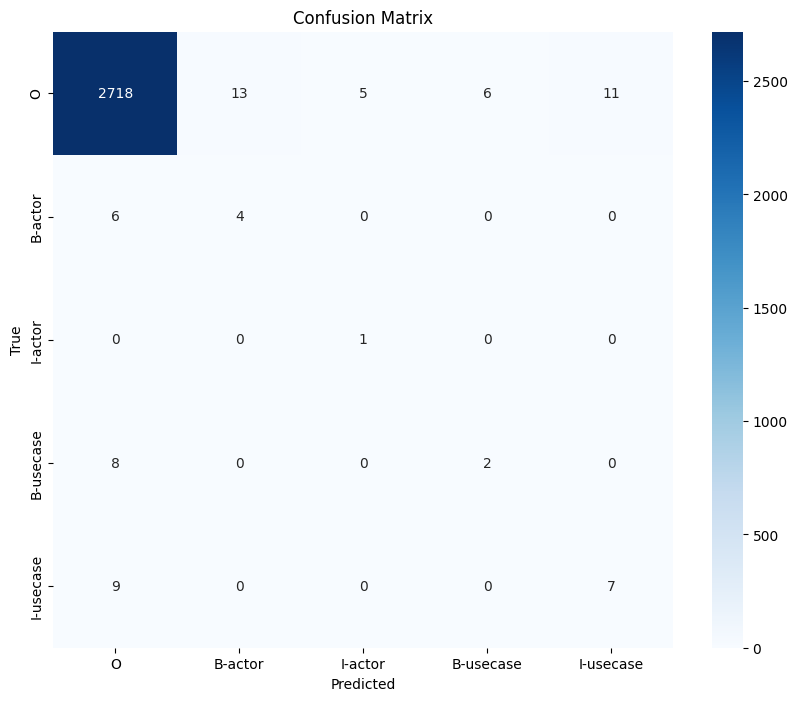

<Figure size 1200x600 with 0 Axes>

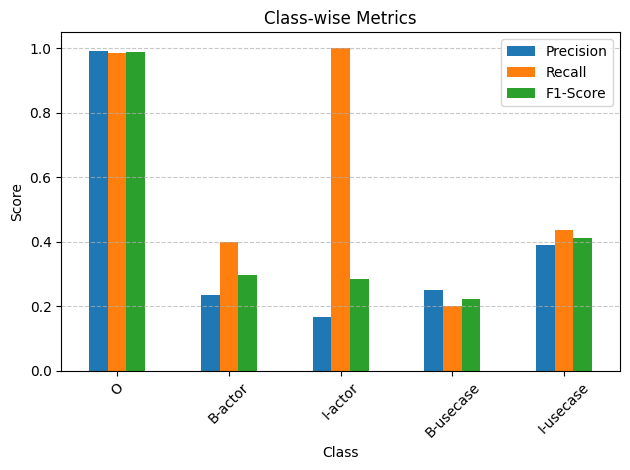

           Precision    Recall  F1-Score  Support
O           0.991609  0.987287  0.989443     2753
B-actor     0.235294  0.400000  0.296296       10
I-actor     0.166667  1.000000  0.285714        1
B-usecase   0.250000  0.200000  0.222222       10
I-usecase   0.388889  0.437500  0.411765       16


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Create confusion matrix
cm = confusion_matrix(test_tags, pred_tags, labels=label_names)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig(f"{output_path}/confusion_matrix.png")
plt.show()

# Calculate and plot class-wise precision, recall, and F1
from sklearn.metrics import precision_recall_fscore_support

precision, recall, f1, support = precision_recall_fscore_support(
    test_tags, pred_tags, labels=label_names, average=None
)

# Create a DataFrame for visualization
metrics_df = pd.DataFrame({
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f1,
    'Support': support
}, index=label_names)

# Plot the metrics
plt.figure(figsize=(12, 6))
metrics_df[['Precision', 'Recall', 'F1-Score']].plot(kind='bar')
plt.title('Class-wise Metrics')
plt.ylabel('Score')
plt.xlabel('Class')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig(f"{output_path}/class_metrics.png")
plt.show()

print(metrics_df)
metrics_df.to_csv(f"{output_path}/class_metrics.csv")

In [13]:
# Example: Show some predictions
def display_predictions(sample_indices=5):
    print("\nSample Predictions:")
    print("-" * 80)
    
    # Take random samples if an integer, otherwise use the provided list of indices
    if isinstance(sample_indices, int):
        indices = np.random.choice(len(test_dataset), sample_indices, replace=False)
    else:
        indices = sample_indices
    
    for idx in indices:
        tokens = test_dataset.iloc[idx]["tokens"]
        true_iob = [label_names[label] for label in test_dataset.iloc[idx]["IOB_tag"]]
        
        # Get predictions for this example
        input_ids = test_inputs[idx].unsqueeze(0).to(device)
        attention_mask = test_masks[idx].unsqueeze(0).to(device)
        
        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask)
            
        logits = outputs.logits.detach().cpu().numpy()
        pred_iob = [id2label[p] for p in np.argmax(logits[0], axis=1)[:len(tokens)]]
        
        # Print aligned tokens and labels
        print(f"Example {idx}:")
        print("=" * 80)
        print("{:<20} {:<10} {:<10}".format("Token", "True", "Predicted"))
        print("-" * 40)
        
        for token, true, pred in zip(tokens, true_iob, pred_iob):
            color = "\033[92m" if true == pred else "\033[91m"  # green if match, red if not
            print("{:<20} {:<10} {}{}{}".format(token, true, color, pred, "\033[0m"))
        
        print("=" * 80)
        print("\n")

# Display some random examples
display_predictions(3)


Sample Predictions:
--------------------------------------------------------------------------------
Example 77:
Token                True       Predicted 
----------------------------------------
We                   O          [PAD]
assign               O          O
each                 O          O
company              O          O
an                   O          O
identifying          O          O
company              O          O
number               O          O
and                  O          O
track                O          O
the                  O          O
company              O          O
’s                   O          O
name                 O          O
and                  O          O
address              O          O
.                    O          O


Example 38:
Token                True       Predicted 
----------------------------------------
The                  O          [PAD]
other                O          O
issue                O          O
is              